# Variational Autoencoders (VAEs) for CryptoPunks Dataset

## Introduction

This Jupyter notebook explores the application of Variational Autoencoders (VAEs) to the CryptoPunks dataset. CryptoPunks are unique digital collectibles on the Ethereum blockchain, consisting of 10,000 algorithmically generated characters with distinct attributes.


In [50]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datasets import load_dataset

In [51]:
# Training on Macbook Pro with M1 chip, using Metal Performance Shaders
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [52]:
# Load the dataset
dataset = load_dataset("huggingnft/cryptopunks", split="train")

# Define split ratio
train_ratio = 0.8

# Create the train-test split
split_dataset = dataset.train_test_split(test_size=1 - train_ratio)

# Access the train and test splits
train_data = split_dataset['train']
test_data = split_dataset['test']

In [53]:
# Function to convert image to tensor
def transform_func(img):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Transform image to 128x128
        transforms.ToTensor(),  # Convert PIL Image to PyTorch tensor
        transforms.ConvertImageDtype(torch.float)   # Convert PIL Image to float
    ])
    return transform(img)

# Define class for Cryptopunks dataset
class PunkDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        self.transform = transform_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image = self.data_list[idx]["image"]
        if isinstance(image, Image.Image):
            image = self.transform(image)
        return image
    
# Initialize the Punk dataset for training and test sets
train_dataset = PunkDataset(train_data)
test_dataset = PunkDataset(test_data)

In [54]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [55]:
# Validate the dataset sizes that they are 80% and 20% of the total dataset
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 8000
Number of test samples: 2000


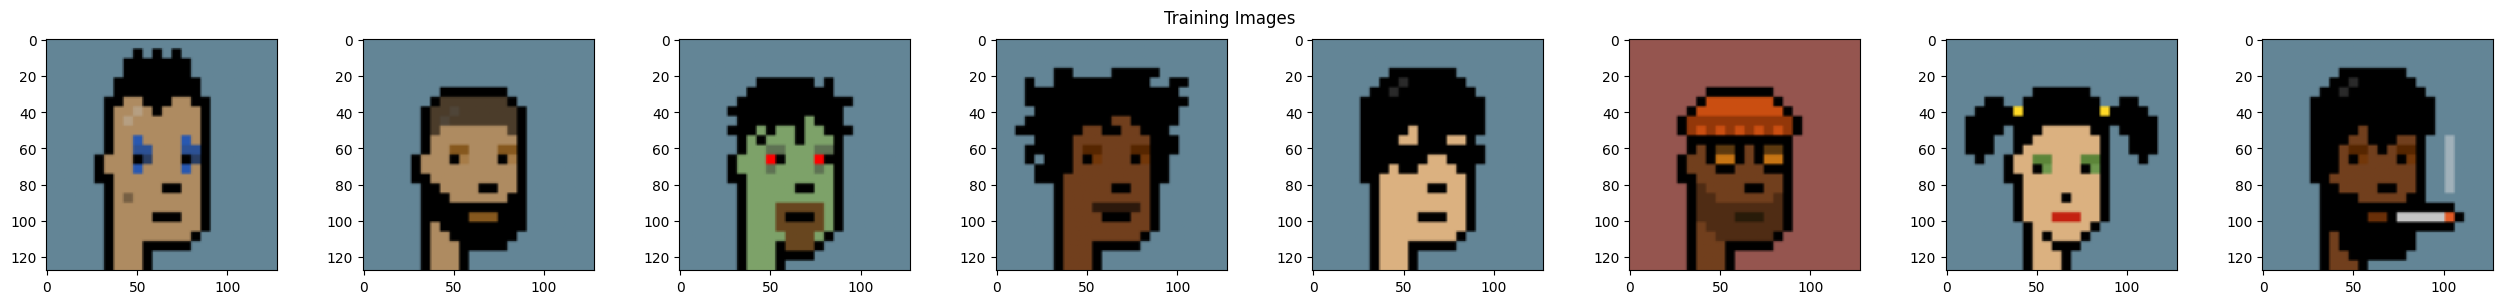

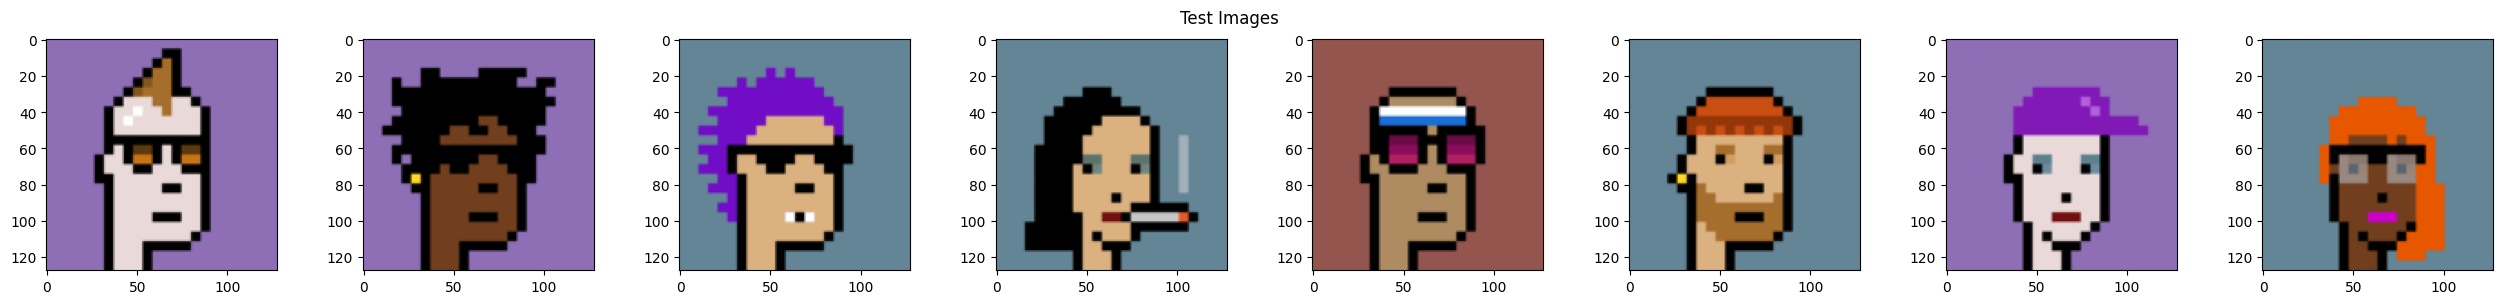

In [56]:
# Display images in a grid
def plot_images_from_loader(data_loader, title, num_images=8):
    """Display a set of images from the DataLoader in a grid."""
    # Get a batch of images
    images = next(iter(data_loader))
    
    # Create a grid from the images
    fig, axes = plt.subplots(1, num_images, figsize=(32, 3))
    fig.suptitle(title)
    
    # Plot each image
    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
        ax.imshow(image)
    plt.show()

# Display images from training and test loaders
plot_images_from_loader(train_loader, title="Training Images")
plot_images_from_loader(test_loader, title="Test Images")

In [88]:
# Encoding network based on a simple forward feed neural network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc_mean = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        mean = self.fc_mean(x) # Mean of the latent space
        logvar = self.fc_logvar(x) # Log variance of the latent space
        return mean, logvar


In [89]:
# Decoding network based on a simple forward feed neural network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 128 * 16 * 16)
        
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = x.view(x.size(0), 128, 16, 16)
        
        x = nn.ReLU()(self.conv1(x))
        x = self.dropout1(x)
        
        x = nn.ReLU()(self.conv2(x))
        x = self.dropout2(x)
        
        x = torch.sigmoid(self.conv3(x))
        return x

In [90]:
# Define the Autoencoder Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    # Reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [85]:
# Initialize the VAE
latent_dim = 128
vae = VAE(latent_dim)

# Define optimizer
optimizer = optim.Adam(vae.parameters(), lr=3e-3, weight_decay=5e-6)

# Updated VAE loss function with MSE and beta coefficient for KL divergence
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    MSE = F.mse_loss(recon_x, x, reduction='sum')  # Mean Squared Error for reconstruction
    KLD = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence with beta coefficient
    return MSE, KLD

# Training loop
def train_vae(dataloader, model, optimizer, num_epochs=20, beta=1.0):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_mse = 0.0
        running_kld = 0.0
        for images in dataloader:
            optimizer.zero_grad()
            
            recon_images, mu, logvar = model(images)
            mse_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta=beta)
            loss = mse_loss + kl_loss
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_mse += mse_loss.item()
            running_kld += kl_loss.item()
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_mse = running_mse / len(dataloader.dataset)
        epoch_kld = running_kld / len(dataloader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {epoch_loss:.4f}, "
              f"MSE Loss: {epoch_mse:.4f}, KL Loss: {epoch_kld:.4f}")

# Train the VAE with beta KL divergence
train_vae(train_loader, vae, optimizer, num_epochs=20, beta=2.1)

Epoch [1/20], Total Loss: 1848.1191, MSE Loss: 1834.7591, KL Loss: 13.3600
Epoch [2/20], Total Loss: 1448.0273, MSE Loss: 1415.5095, KL Loss: 32.5179
Epoch [3/20], Total Loss: 1272.9043, MSE Loss: 1228.4167, KL Loss: 44.4876
Epoch [4/20], Total Loss: 1206.7239, MSE Loss: 1157.7883, KL Loss: 48.9356
Epoch [5/20], Total Loss: 1135.8897, MSE Loss: 1085.3082, KL Loss: 50.5814
Epoch [6/20], Total Loss: 1097.1180, MSE Loss: 1047.6403, KL Loss: 49.4777
Epoch [7/20], Total Loss: 1066.0869, MSE Loss: 1017.0298, KL Loss: 49.0571
Epoch [8/20], Total Loss: 1039.6578, MSE Loss: 990.5910, KL Loss: 49.0668


KeyboardInterrupt: 

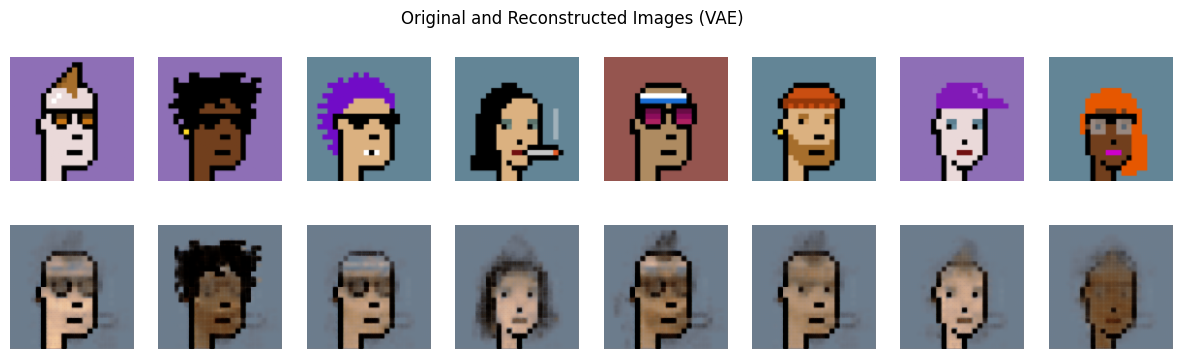

In [86]:
# Function to display original and reconstructed images
def plot_vae_results(data_loader, model, num_images=8):
    model.eval()
    
    with torch.no_grad():
        images = next(iter(data_loader))
        recon_images, _, _ = model(images)
    
    # Convert images and reconstructed images to NumPy arrays for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 4))
    fig.suptitle("Original and Reconstructed Images (VAE)")
    
    # Display original images
    for i in range(num_images):
        ax = axes[0, i]
        img = images[i].transpose(1, 2, 0)
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
    
    # Display reconstructed images
    for i in range(num_images):
        ax = axes[1, i]
        img = recon_images[i].transpose(1, 2, 0)
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
    
    plt.show()

# Call the function to display images
plot_vae_results(test_loader, vae, num_images=8)

In [ ]:
# Save the model state dictionary
torch.save(vae.state_dict(), 'autoencoder.pth')

# Save the entire model
torch.save(vae, 'autoencoder_complete.pth')